In [27]:
import numpy as np
import math
import scipy.io as sio
import matplotlib.pyplot as plt
import torch.utils.data
from sklearn.model_selection import train_test_split
from beam_utils import calc_beam_pattern
import torch
from DL_utils import Joint_BF_Autoencoder,eval_model
import DeepMIMO
from os.path import exists
import pandas

### Experiment settings: default parameters

In [21]:
# Default parameters
n_probing_beam = None # defaul number of probing beams
noise_power_dBm = -81 # noise power dBm
measurement_gain = 16.0 # spreading gain of probing measurements
measurement_gain_dB = 10*np.log10(measurement_gain)
gamma = 0.3 # trade-off between BF loss and misdetection loss
h_NMSE_dB = -np.inf # channel NMSE in dB, to generate noisy training data
IA_threshold = -5 # initial access SNR threshold in dB


In [22]:
scenario = 'O1_28B' # DeepMIMO Ray-tracing scenario
activated_BS = 3 # Index of activated BS in the scenario
array_type = 'ULA' # BS and UE array type, ULA or UPA
random_UE_rotation = False

# Set the BS transmit power in dBm
if scenario == 'O1_28':
    tx_power_dBm = 20
elif scenario == 'O1_28B':
    tx_power_dBm = 35    
elif scenario == 'I3_60':
    if activated_BS==1:
        tx_power_dBm = 15
    elif activated_BS==2:
        tx_power_dBm = 20
    else:
        raise Exception("Unsupported BS activation!") 
else:
    raise Exception("Unsupported Ray-Tracing Scenario!")

# UE grid depending on the scenario
if scenario == 'O1_28':
    BS_arr = np.array([3])
    ue_row_first = 800
    ue_row_last = 1200
elif scenario == 'O1_28B':
    BS_arr = np.array([3])
    ue_row_first = 1
    ue_row_last = 2751    
elif scenario == 'I3_60':
    BS_arr = np.array([activated_BS])
    ue_row_first = 1
    ue_row_last = 1159
else:
    raise Exception("Unsupported Ray-Tracing Scenario!")

# Generate the DeepMIMO dataset
parameters = DeepMIMO.default_params()
parameters['dataset_folder'] = 'D:/Github Repositories/DeepMIMO-codes/DeepMIMOv2/Raytracing_scenarios' # replace with your DeepMIMO dataset folder

parameters['scenario'] = scenario
parameters['num_paths'] = 25
parameters['active_BS'] = BS_arr
parameters['user_row_first'] = ue_row_first
parameters['user_row_last'] = ue_row_last
parameters['row_subsampling'] = 1
parameters['user_subsampling'] = 1

parameters['bs_antenna']['shape'] = np.array([1, 64, 1])
parameters['bs_antenna']['spacing'] = 0.5
parameters['bs_antenna']['radiation_pattern'] = 'isotropic'

parameters['ue_antenna']['shape'] = np.array([1, 16, 1])
parameters['ue_antenna']['spacing'] = 0.5
if random_UE_rotation:
    parameters['ue_antenna']['rotation'] = np.array([[-180,180],[-90,90],[-90,90]])
parameters['ue_antenna']['radiation_pattern'] = 'isotropic'

parameters['enable_BS2BS'] = 0

parameters['OFDM_channels'] = 1 # Frequency (OFDM) or time domain channels
parameters['OFDM']['subcarriers'] = 512
parameters['OFDM']['subcarriers_limit'] = 1
parameters['OFDM']['subcarriers_sampling'] = 1
parameters['OFDM']['bandwidth'] = 0.1
parameters['OFDM']['RX_filter'] = 0

dataset = DeepMIMO.generate_data(parameters)
h = dataset[0]['user']['channel'].squeeze()

eigen_bf_gain_path = './Data/eigen_bf_gain_{}_BS_{}_BS_array_{}x{}x{}_UE_array_{}x{}x{}.npy'.format(parameters['scenario'],parameters['active_BS'][0],
                                                                                        parameters['bs_antenna'][0]['shape'][0],parameters['bs_antenna'][0]['shape'][1],parameters['bs_antenna'][0]['shape'][2],
                                                                                        parameters['ue_antenna']['shape'][0],parameters['ue_antenna']['shape'][1],parameters['ue_antenna']['shape'][2])
if exists(eigen_bf_gain_path):
    eigen_bf_gain = np.load(eigen_bf_gain_path,allow_pickle=True)
else:
    eigen_bf_gain = np.linalg.eigvalsh(np.transpose(h.conj(),axes=(0,2,1)) @ h)[:,-1] # compute the max eigenvalue of the channel covariance matrix, this is the uppero bound of the BF gain
    np.save(eigen_bf_gain_path,eigen_bf_gain,allow_pickle=True)
eigen_snr = tx_power_dBm+10*np.log10(eigen_bf_gain)-noise_power_dBm # SNR with eigen beamforming
reachable_ue = eigen_snr>IA_threshold   # remove UEs that are impossible to complete IA with eigen beamforming
print('Removed {} out of {} UEs that are below the IA SNR threshold ({} dB).'.format((~reachable_ue).sum(),h.shape[0],IA_threshold))    
h = h[reachable_ue]

norm_factor = np.max(abs(h))
h_scaled = (h.T/norm_factor).T


Basestation 3

UE-BS Channels


Generating channels: 100%|██████████| 497931/497931 [06:59<00:00, 1186.19it/s]
C:\Users\ethan\AppData\Local\Temp\ipykernel_181348\3060778567.py:79: RuntimeWarning: divide by zero encountered in log10
  eigen_snr = tx_power_dBm+10*np.log10(eigen_bf_gain)-noise_power_dBm # SNR with eigen beamforming


Removed 25087 out of 497931 UEs that are below the IA SNR threshold (-5 dB).


In [23]:
# Training and testing data:
# --------------------------
train_idc, test_idc = train_test_split(np.arange(h.shape[0]),test_size=0.4,random_state=7)
val_idc, test_idc = train_test_split(test_idc,test_size=0.5,random_state=7)

x_train,x_val,x_test = h_scaled[train_idc],h_scaled[val_idc],h_scaled[test_idc]

torch_x_train = torch.from_numpy(x_train)
torch_x_val = torch.from_numpy(x_val)
torch_x_test = torch.from_numpy(x_test)

num_antenna_Tx = np.prod(parameters['bs_antenna'][0]['shape'])
num_antenna_Rx = np.prod(parameters['ue_antenna']['shape'])

In [24]:
beam_prediction_mode = 'GF'
num_feedback = None
feedback_mode = 'diagonal'
learned_probing = 'TxRx'
beam_synthesizer = 'MLP'
loss_fn = 'BF_IA_loss'
train_noise_power = 10**((noise_power_dBm-tx_power_dBm)/10)/measurement_gain # probing measurements SNR

### Extract the learned probing and sensing codebooks, predicted beams for all UEs with different number of probing beams

In [43]:
tx_beam_dict = {}
rx_beam_dict = {}
tx_probing_codebook_dict = {}
rx_probing_codebook_dict = {}
pred_bf_gain_dict = {}
model_savefname_prefix = './Models/'
for n_probing_beam in [4,24]:
    model = Joint_BF_Autoencoder(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx, 
                                 num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                                 noise_power=train_noise_power, norm_factor=norm_factor,
                                 feedback=feedback_mode,num_feedback = num_feedback,
                                 learned_probing = learned_probing, beam_synthesizer = beam_synthesizer).cpu()      
    model_setup_params = ("{}_BS_{}_{}_"+
                    "UE_rot_{}_"+
                    "{}_{}_probe_"+
                    "{}_FB_{}_"+
                    "{}_"+
                    "{}_gamma_{}_"+
                    "train_noise_{}_dBm_"+
                    "meas_gain_{}_"+
                    "IA_thresh_{}_"+
                    "h_NMSE_{}").format(parameters['scenario'], parameters['active_BS'][0],beam_prediction_mode,
                                        random_UE_rotation,
                                        n_probing_beam, learned_probing,
                                        feedback_mode, num_feedback,
                                        beam_synthesizer,
                                        loss_fn, gamma,
                                        noise_power_dBm,
                                        measurement_gain,
                                        IA_threshold,
                                        h_NMSE_dB)
    try:
        state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
        model.load_state_dict(state_dict_load)
    except FileNotFoundError:
        print(n_probing_beam)      
    model.eval()
    with torch.no_grad():
        tx_beam_pred, rx_beam_pred,_ = model(torch_x_test)
        rx_beam_pred = rx_beam_pred.detach().unsqueeze(dim=-1).numpy() # n_batch x num_antenna_Rx x 1
        tx_beam_pred = tx_beam_pred.detach().unsqueeze(dim=-1).numpy() # n_batch x num_antenna_Tx x 1
    tx_beam_dict[n_probing_beam] = tx_beam_pred
    rx_beam_dict[n_probing_beam] = rx_beam_pred
    
    predicted_bf_gain = np.transpose(rx_beam_pred.conj(),axes=(0,2,1)) @ h[test_idc] @ tx_beam_pred
    predicted_bf_gain = np.power(np.absolute(predicted_bf_gain),2).squeeze() 
    sq_norm = np.linalg.norm(h[test_idc],axis=(1,2))**2
    predicted_bf_gain = predicted_bf_gain/sq_norm
    pred_bf_gain_dict[n_probing_beam] = predicted_bf_gain
    
    probing_codebook_Tx,probing_codebook_Rx = model.get_probing_codebooks()
    tx_probing_codebook_dict[n_probing_beam] = probing_codebook_Tx
    rx_probing_codebook_dict[n_probing_beam] = probing_codebook_Rx

e:\Anaconda\envs\p39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Plot the learned probing and sensing beam patterns
### Plot the predicted Tx and Rx beams for a specified UE and its true AoA and AoD

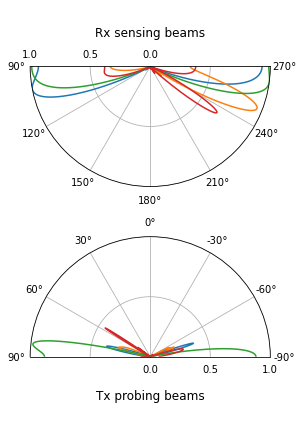

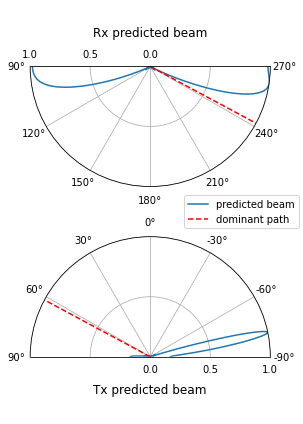

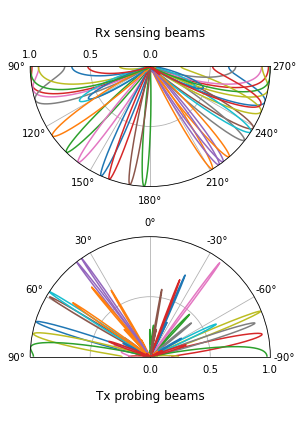

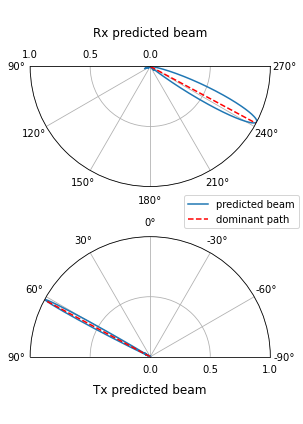

In [42]:
ue_sample = 50000

for n_probing_beam in [4,24]:
    fig = plt.figure(figsize=(4,6))
    ax = fig.add_subplot(211,polar=True)
    for beam_i, beam in enumerate(rx_probing_codebook_dict[n_probing_beam].T):
        phi, bf_gain = calc_beam_pattern(np.flip(beam),phi_min=np.pi/2,phi_max=3*np.pi/2,n_antenna=num_antenna_Rx)
        ax.plot(phi,bf_gain)
    ax.grid(True)
    ax.set_rmax(1)
    ax.set_rticks([0,0.5, 1])
    ax.set_rlabel_position(270)  # Move radial labels away from plotted line
    ax.set_thetamin(90)
    ax.set_thetamax(270)
    ax.set_theta_zero_location("N")
    ax.set_title('Rx sensing beams',y=0.85)

    ax = fig.add_subplot(212,polar=True)
    for beam_i, beam in enumerate(tx_probing_codebook_dict[n_probing_beam].T):
        phi, bf_gain = calc_beam_pattern(beam,phi_min=-np.pi/2,phi_max=np.pi/2,n_antenna=num_antenna_Tx)
        ax.plot(phi,bf_gain)
    ax.grid(True)
    ax.set_rmax(1)
    ax.set_rticks([0,0.5, 1])
    ax.set_rlabel_position(-90)  # Move radial labels away from plotted line
    ax.set_thetamin(-90)
    ax.set_thetamax(90)
    ax.set_theta_zero_location("N")
    ax.set_title('Tx probing beams',y=0.05)

    fig.tight_layout(h_pad=-7)
    plt.show()
        
    aoa_az = np.deg2rad(dataset[0]['user']['paths'][reachable_ue.nonzero()[0][test_idc][ue_sample]]['DoA_phi'])
    aod_az = np.deg2rad(dataset[0]['user']['paths'][reachable_ue.nonzero()[0][test_idc][ue_sample]]['DoD_phi'])
    path_gain = dataset[0]['user']['paths'][reachable_ue.nonzero()[0][test_idc][ue_sample]]['power']
    path_gain = path_gain/path_gain.max()
    
    fig = plt.figure(figsize=(4,6))
    ax = fig.add_subplot(211,polar=True)
    phi, bf_gain = calc_beam_pattern(np.flip(rx_beam_dict[n_probing_beam][ue_sample]),phi_min=np.pi/2,phi_max=3*np.pi/2,n_antenna=num_antenna_Rx)
    ax.plot(phi,bf_gain,label='predicted beam')
    ax.vlines(aoa_az[0],0,1,'r',linestyles='dashed')
    ax.grid(True)
    ax.set_rmax(1)
    ax.set_rticks([0,0.5, 1])
    ax.set_rlabel_position(270)  # Move radial labels away from plotted line
    ax.set_thetamin(90)
    ax.set_thetamax(270)
    ax.set_theta_zero_location("N")
    ax.set_title('Rx predicted beam',y=0.85)

    ax = fig.add_subplot(212,polar=True)
    phi, bf_gain = calc_beam_pattern(tx_beam_dict[n_probing_beam][ue_sample],phi_min=-np.pi/2,phi_max=np.pi/2,n_antenna=num_antenna_Tx)
    ax.plot(phi,bf_gain,label='predicted beam')
    ax.vlines(aod_az[0],0,1,'r',linestyles='dashed',label='dominant path')
    ax.grid(True)
    ax.set_rmax(1)
    ax.set_rticks([0,0.5, 1])
    ax.set_rlabel_position(-90)  # Move radial labels away from plotted line
    ax.set_thetamin(-90)
    ax.set_thetamax(90)
    ax.set_theta_zero_location("N")
    ax.set_title('Tx predicted beam',y=0.075)
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')

    fig.tight_layout(h_pad=-7)
    plt.show()